In [174]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split

### Are you sure your model returns probabilities? 🎲

Most machine learning models for classification output numbers between 0 and 1 that we tend to interpret as probabilities of the sample belonging to respective classes. In scikit-learn, for instance, we can obtain them by calling a predict_proba() method on the model. Proba, like in 'probabilities', right? These numbers typically sum up to one for all classes, confirming our belief that they are probabilities. But are they? Well, usually no, and here is why.

### What is a probability anyway?

Well, okay, these numbers are probabilities in some sense, but not in a sense that we want them to be. They fulfill most conditions to be treated as such: they are between 0 and 1, sum up to 1, and have the property that the higher the number, the more likely the class membership of the respective sample. The last point means that if you only care about the hard classification, you can sort your samples by these pseudo-probabilities and apply thresholding to take x% of the most likely samples per class, for instance. 

However, if you also care about certainty in your classification, these numbers are no good. This is because they are not probabilities in the frequentist sense. What does this mean? A frequentist will tell you that "an event's probability is the limit of its relative frequency in many trials".

For example, why is the probability of rolling six with a dice 1/6? Because if you rolled it 6 000 000 times, you'd get approximately 1 000 000 sixes. And if you rolled it infinitely many times, then exactly 1/6 rolls will come up six.

How does this relate to classification models? If your model would produce probabilities in the frequentist sense, then out of all situations when the model predicts 80% probability of class 1, it would be correct in approximately 80% cases.

As we have said, this is not the case for most models. But why is it important? Let's make it practical and try to win some cash from betting football matches.

### Betting on football games

I have gathered a dataset containing outcomes of football games in the English Premier League for the past few years. One row is one game. It looks like this:

In [215]:
games = pd.read_csv("games.csv")
games.head()

,result,home_elo,away_elo,home_recent_goals_scored_home,home_recent_goals_scored_away,home_recent_goals_conceded_home,home_recent_goals_conceded_away,home_recent_home_games_won,home_recent_home_games_lost,home_recent_away_games_won,home_recent_away_games_lost,away_recent_goals_scored_home,away_recent_goals_scored_away,away_recent_goals_conceded_home,away_recent_goals_conceded_away,away_recent_home_games_won,away_recent_home_games_lost,away_recent_away_games_won,away_recent_away_games_lost
0,D,1778.129761,1882.825928,0,3,0,2,0,0,1,0,1,0,0,0,1,0,0,0
1,A,1554.260986,1666.789307,0,0,0,2,0,0,0,1,0,0,0,0,0,1,0,0
2,H,1875.017944,1665.362183,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
3,H,1643.928223,1770.275757,0,0,0,3,0,0,0,1,4,0,0,0,1,0,0,0
4,D,1652.127808,1642.754761,0,0,0,0,0,0,0,1,4,0,1,0,1,0,0,0


The result column states who won the game: Home team, Away team, or there was a Draw. Will we build a binary classifier trying to predict if the home team wins. There are 18 features in the data set: ELO ratings of both teams as well as many different statistics summing up how good each team was in the recent games with respect to attack and defense. If we can predict whether the home team wins, we will bet on them and be rich. 

There are 5588 games in the data set. I have put aside one-tenth of them as a test set and fit a random forest to the remaining training set. Since there are many features, we will reduce dimensionality first using principal components.

In [195]:
y = (games["result"] == "H").values
X = games.drop("result", axis=1).values
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=42
)

pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=5),
    RandomForestClassifier()
)

pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.629695885509839

We got a score of 0.63. Not good, not terrible. Certainly better than a dummy model which always predicts a home win - such a model would score the accuracy of 0.46 (as the hosts tend to win almost half of the games).

In [176]:
def plot_calibration(df):
    plt.figure(figsize=(6, 6))
    plt.plot(df["grouper"], df["y_true"], color='xkcd:darkish blue', lw=3, 
             zorder=0, label="Not calibrated")
    plt.scatter(df["grouper"], df["y_true"], color='xkcd:lightish blue',
                edgecolor="black", s=100, zorder=1, label="Not calibrated")
    plt.axis("equal")
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel("Predicted probability bin", fontsize=15)
    plt.ylabel("Observed probability", fontsize=15)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=3, color='xkcd:terra cotta')
    plt.annotate("Perfect\nCalibration\nLine", (0.7, 0.9), fontsize=12,
                 color='xkcd:terra cotta')
    plt.grid(alpha=0.25)
    plt.legend()

### Calibration curve

Before you rush to the betting website, check out the calibration curve. It tells you how much off are the probabilities returned by the model from the ideal frequentist probabilities. We compute it here on the test data in the following manner: we bin all the predicted probabilities into bins of width 0.1, and for each bin, we calculate the percentage of samples in which the home team won:

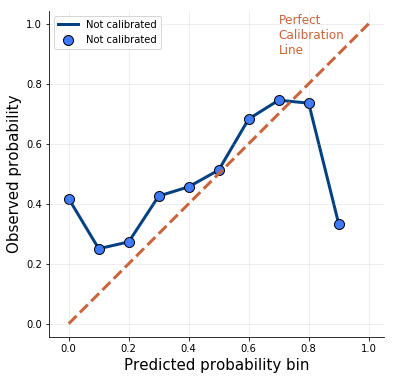

In [196]:
df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": np.squeeze(pipeline.predict_proba(X_test)[:, pipeline.classes_])
})

df.sort_values("y_pred", inplace=True)
df["grouper"] = (df["y_pred"] // 0.1) / 10
df = df.groupby("grouper")["y_true"].mean().reset_index()

plot_calibration(df)

You could also get similar results quicker by using the scikit-learn's calibration_curve() function, but the manual job we've done tells you explicitely what's happened. We can now plot the resultingdf to get the so-called calibration curve:

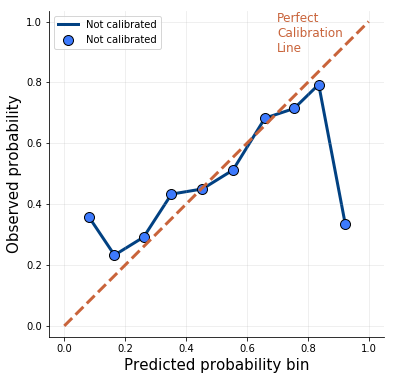

In [207]:
from sklearn.calibration import calibration_curve
probs = np.squeeze(pipeline.predict_proba(X_test)[:, pipeline.classes_])
fop, mpv = calibration_curve(y_test, probs, n_bins=10)
dfa = pd.DataFrame({
    "grouper": mpv,
    "y_true": fop
})
plot_calibration(dfa)

Ideally, all points should be on the diagonal. That would mean the model is perfectly calibrated and its probability estimates are trustworthy. However, this is not the case.

What is the case is that if the model predicts between 0% and 10% probability of the home team winning (first bin on the horizontal axis), in reality, the hosts win in about 40% of the cases. What if we bet only on the games for which the model is really certain about the home win (>90% probability)? We would get it right in approximately 30% of the games only. This is a terrible betting strategy!

### Why so uncalibrated?

The calibration curve we've just seen displays an S-shaped pattern. This is often the case for many classification models, and the consequence is over-forecasting low probabilities and under-forecasting high probabilities.

So, why do many models produce such biased probability estimates, especially for very low and high values? The reasons are slightly different for each model depending on how it works. Here, we have used a random forest, which is an ensemble of decision trees. The forest's prediction is made by averaging individual trees' predictions, and there is always some variance among them. Due to the fact that probabilities are bounded by [0, 1], there will always be some bias at the borders of this interval. For instance, say a model should predict a probability of zero for some test sample. Some of the underlying trees will correctly predict zero, but some will predict a slightly higher value. Taking the average pushes the forest's prediction away from zero. This effect is similar but opposite on the other side of the [0, 1] interval.

A lot of other classifiers, such as naive Bayes, SVMs, or decision trees will also produce an S-shaped calibration curve. The general reason for this is that most classification models optimize for and are scored by binary metrics. Accuracy only looks at whether we are right or wrong, disregarding certainty. Gini-impurity used by decision trees to decide on splits optimizes for being as accurate as possible as quickly as possible. Examples are numerous.

### Calibrating the model
Luckily, there is a way to fix, i.e. calibrate, the probability estimates. Actually, there are even two! 

One is to feed the probability estimates from, say, a random forest to a logistic regression model and train it with the original targets. This works, because logistic regression is a rare beast that actually produces calibrated probabilities. The secret behind it is that it optimizes for log-odds, which makes probabilities actually present in the model's cost function. This approach is known as Platt-scaling.

Another one is the so-called isotonic regression. It's a non-parametric model that fits a piecewise constant, non-decreasing function to the probabilities predicted by a random forest, for instance, in order to map them onto the true probability space.

The practical difference between using these two methods is that Platt-scaling is better at correcting S-shaped probability estimates, like the one we have obtained for out football dataset. Isotonic regression, on the other hand, can handle any bias shape but at the cost of being prone to overfitting. In practice, I'd recommend going for Platt-scaling, unless you see it not working well and your data set is large.

Note that whichever method you pick, the calibration model should be based on different data than that to which a random forest was fit. Hence, you either need a separate validation set (you fit the random forest to the train set, make probability predictions for the validation targets, and fit the calibration model predicting validation targets from random forests' predictions on these targets), or you can simply use cross-validation, as we will do now.

Calibrating a classifier is as easy as passing it to scikit-learn's CalibratedClassiferCV. The method argument can be either sigmoid (the default, for logistic regression a.k.a. Platt-scaling) or isotonic.

Let's now draw the calibration curve for this new, calibrated model on top of the previous one.

In [214]:
calibrated_pipeline = make_pipeline(
    StandardScaler(),
    PCA(n_components=5),
    CalibratedClassifierCV(
        RandomForestClassifier(), method="sigmoid"
    )
)

calibrated_pipeline.fit(X_train, y_train)
calibrated_pipeline.score(X_test, y_test)

0.6243291592128801

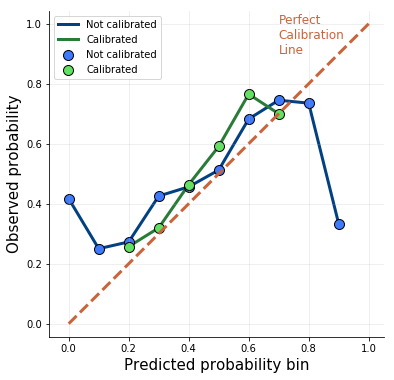

In [198]:
calibrated_df = pd.DataFrame({
    "y_true": y_test,
    "y_pred": np.squeeze(
        calibrated_pipeline.predict_proba(X_test)[:, calibrated_pipeline.classes_]
    )
})

calibrated_df.sort_values("y_pred", inplace=True)
calibrated_df["grouper"] = (calibrated_df["y_pred"] // 0.1) / 10
calibrated_df = calibrated_df.groupby("grouper")["y_true"].mean().reset_index()

plot_calibration(df)
plt.plot(calibrated_df["grouper"], calibrated_df["y_true"], 
         color='xkcd:darkish green', lw=3, zorder=0, label="Calibrated")
plt.scatter(calibrated_df["grouper"], calibrated_df["y_true"], 
            color='xkcd:lightish green', edgecolor="black", s=100, zorder=1, 
            label="Calibrated")
plt.legend()
plt.show()

There are two interesting things to see here:
* The calibrated probability estimates are, errr, calibrated. They are on average closer to the diagonal and hence more reliable.
* The calibrated model does not output extreme probabilities at all. The lowest it produced was in the 20s and the highest in the 70s. This is a common pattern.

One final remark: calibrating the model does not guarantee an improvement in its class assignment capabilities. Metrics such as accuracy, precision, or recall can even go down at times. In this case, the accuracy of the calibrated model is 62%, compared to the raw random forest's 63%. However, calibration gets the probabilities right and we're not losing a fortune to a bookmaker.

### Conclusions

* Many classification models, such as random forest, decision trees, support vector machines, or naive Bayes return biased probability estimates of class membership.
* These biased probabilities can be used for thresholding, but cannot be held as certainty measures. For instance, if according to such a model, one sample has a probability of 70% of belonging to some class, and another one has 50%, then the former is indeed more likely to belong to this class, but the probability of this being true need not in reality amount to 70%.
* This is especially true for very high and low predicted probability: if the model predicts 2%, the real probability is likely more than this; if it predicts 97%, it's typically less.
* The process of fixing the biased probabilities is known as calibration. It boils down to training a calibrating classifier on top of the initial model. Two popular calibration models are logistic and isotonic regression.
* Training a calibration model requires having a separate validation set or performing cross-validation to avoid overfitting.
* It's all very easy to do in scikit-learn.